In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme()

import torch 
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.set_default_dtype(torch.float32)

%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [15]:
# Expressive LSTM v2
class ProLSTM2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ProLSTM2, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=2, bidirectional=True, batch_first=True)
        self.linear1 = nn.Linear(hidden_size, hidden_size) # nn.Linear(hidden_size * 2, hidden_size) for self lstm_out
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
        self.activation = nn.PReLU()
    
    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros((4, batch_size, 1024), device=device, requires_grad=True)
        c0 = torch.zeros((4, batch_size, 1024), device=device, requires_grad=True)
        out, (hn, cn) = self.lstm(x.view(batch_size, 1, -1), (h0, c0))
        out = self.activation(self.linear1(hn[0]))
        out = self.activation(self.linear2(out))
        out = self.linear3(out)
        return out

In [12]:
# Custom Dataset Loader 
class TrajDataset(Dataset):
    """Expert Trajectory Dataset."""
    def __init__(self, data):
        
        # Inputs
        self.x = data[:, :-1]
        
        # Output
        self.y = data[:, -1]
        
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        
        # Inputs
        inp = self.x[idx]
        inp = inp.flatten()
        
        # Outputs
        out = self.y[idx]
        out = out.flatten()
        
        return torch.tensor(inp).float(), torch.tensor(out).float()

# Load the dataset
train_data = np.load("./Dataset/train_23_03.npy")
val_data = np.load("./Dataset/val_23_03.npy")
test_data = np.load("./Dataset/test_23_03.npy")

# Using PyTorch Dataloader
train_dataset = TrajDataset(train_data)
val_dataset = TrajDataset(val_data)
test_dataset = TrajDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=0)

In [13]:
for batch_num, (datas) in enumerate(train_loader):
    inp, out = datas
    print(inp.shape, out.shape)
    break

torch.Size([256, 8]) torch.Size([256, 1])


In [16]:
# ToyMLP Inputs
input_size = 8
hidden_size = 1024
output_size = 1

epochs = 210
model = ProLSTM2(input_size, hidden_size, output_size).to(device)
optimizer = optim.AdamW(model.parameters(), lr = 6e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma = 0.1)
loss_fn = nn.MSELoss()

avg_train_loss, avg_val_loss = [], []
for epoch in range(epochs):

    # Train Loop
    losses_train = []
    model.train()
    for inp, out in train_loader:

        inp = inp.to(device)
        out = out.to(device)

        # Forward Pass
        pred = model(inp)
        loss = loss_fn(pred, out)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses_train.append(loss.detach().cpu().numpy())

    # Test Loop
    losses_val = []
    model.eval()
    for inp, out in val_loader:

        inp = inp.to(device)
        out = out.to(device)

        # No Gradients
        with torch.no_grad():
            pred = model(inp)
            test_loss = loss_fn(pred, out)

        losses_val.append(test_loss.detach().cpu().numpy())

    print(f"Epoch: {epoch + 1}, Train Loss: {np.average(losses_train):.3f},  Val Loss: {np.average(losses_val):.3f}")

    scheduler.step()
    avg_train_loss.append(np.average(losses_train)), avg_val_loss.append(np.average(losses_val))

Epoch: 1, Train Loss: 0.367,  Val Loss: 0.159
Epoch: 2, Train Loss: 0.203,  Val Loss: 0.204
Epoch: 3, Train Loss: 0.191,  Val Loss: 0.183
Epoch: 4, Train Loss: 0.177,  Val Loss: 0.136
Epoch: 5, Train Loss: 0.155,  Val Loss: 0.156
Epoch: 6, Train Loss: 0.181,  Val Loss: 0.143
Epoch: 7, Train Loss: 0.165,  Val Loss: 0.156
Epoch: 8, Train Loss: 0.214,  Val Loss: 0.165
Epoch: 9, Train Loss: 0.280,  Val Loss: 0.245
Epoch: 10, Train Loss: 0.254,  Val Loss: 0.135
Epoch: 11, Train Loss: 0.186,  Val Loss: 0.182
Epoch: 12, Train Loss: 0.169,  Val Loss: 0.125
Epoch: 13, Train Loss: 0.154,  Val Loss: 0.128
Epoch: 14, Train Loss: 0.151,  Val Loss: 0.179
Epoch: 15, Train Loss: 0.152,  Val Loss: 0.134
Epoch: 16, Train Loss: 0.134,  Val Loss: 0.123
Epoch: 17, Train Loss: 0.130,  Val Loss: 0.125
Epoch: 18, Train Loss: 0.128,  Val Loss: 0.122
Epoch: 19, Train Loss: 0.128,  Val Loss: 0.121
Epoch: 20, Train Loss: 0.127,  Val Loss: 0.119
Epoch: 21, Train Loss: 0.126,  Val Loss: 0.118
Epoch: 22, Train Loss:

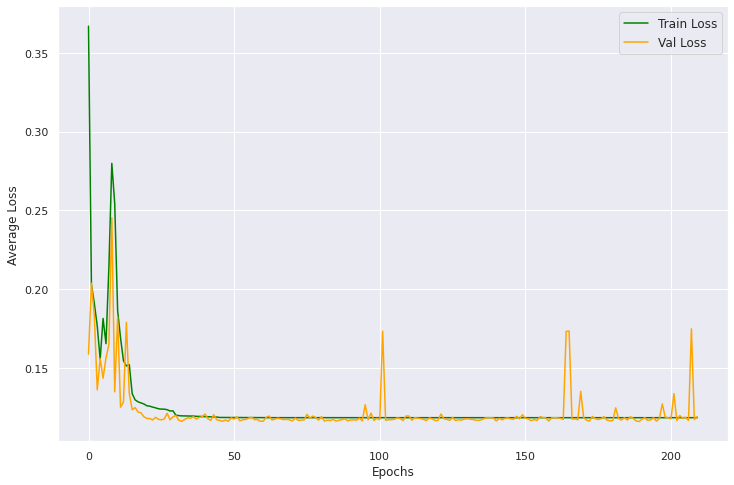

In [17]:
e = np.arange(epoch+1)

plt.figure( figsize=(12, 8))
plt.plot(e, np.array(avg_train_loss), label="Train Loss", color="green")
plt.plot(e, np.array(avg_val_loss), label="Val Loss", color="orange")
plt.legend(loc=1 ,prop={'size': 12})
# plt.ylim([0, 30])
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.show()

In [18]:
# Load the Test Dataset
test_set = torch.from_numpy(test_data)

# Feature and Ground Truth Matrix
X = test_set[:, :-1].to(device)
y = test_set[:, -1].reshape(-1, 1).to(device)

# Inference
with torch.no_grad():
    model.eval()
    test_pred = model(X)

test_loss = loss_fn(test_pred, y)    

print(f"Test MSE Loss: {test_loss:.3f}")

test_set.shape, X.shape, y.shape, test_pred.shape

Test MSE Loss: 0.154


(torch.Size([5476, 9]),
 torch.Size([5476, 8]),
 torch.Size([5476, 1]),
 torch.Size([5476, 1]))

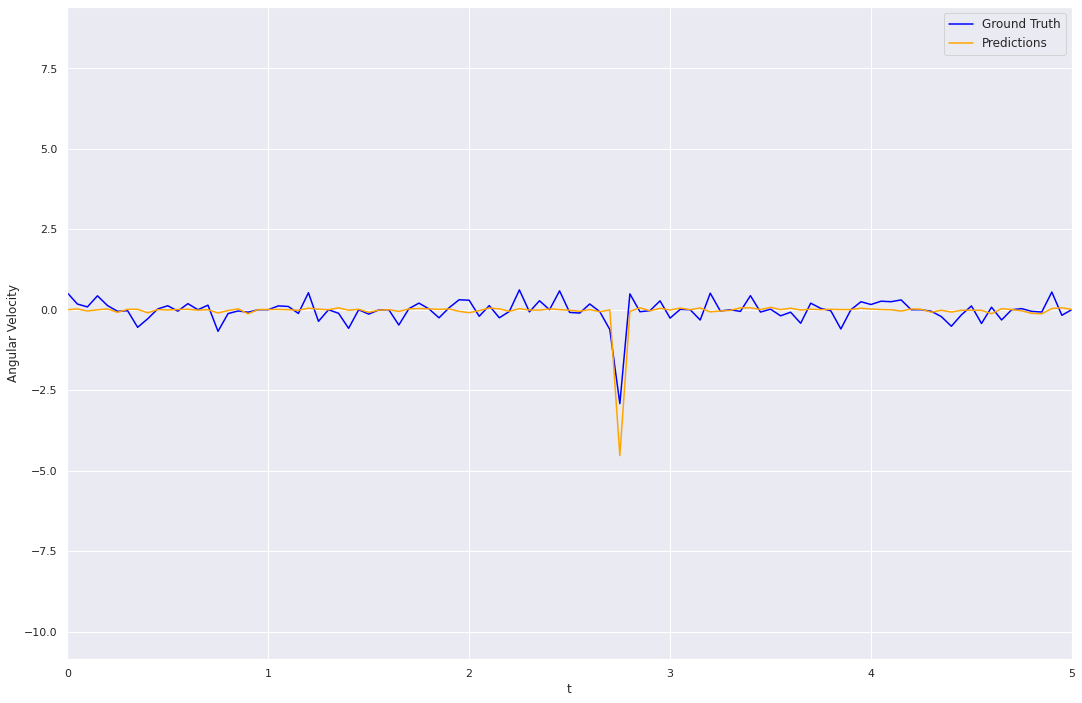

In [19]:
t = np.linspace(0, X.shape[0], X.shape[0])*0.05

# %matplotlib qt
plt.figure( figsize=(18, 12))
plt.plot(t, y.cpu().numpy(), label="Ground Truth", color="blue")
plt.plot(t, test_pred.cpu().numpy(), label="Predictions", color="orange")
plt.legend(loc=1 ,prop={'size': 12})
plt.xlim(0, 5)
# plt.ylim(-10, 10)
plt.xlabel("t")
plt.ylabel("Angular Velocity")
# plt.savefig("GRU Predictions.png")
plt.show()